In [1]:
import torch
import torchvision
import os
from IPython.display import Image, display
import math
import matplotlib.pyplot as plt

# --- Import your models and scheduler ---
# (Make sure models.py and scheduler.py are in the same directory)
from utils.models import SimpleModel, UNetModel, AdvUNetModel
from utils.scheduler import Alpha_NoiseScheduler
from utils.tools import denormalize


# --- Define Constants ---
device = "cuda" if torch.cuda.is_available() else "cpu"
num_steps = 2000 # T=999 is the last step

steps_to_display = [num_steps-1, 999, 799, 599, 399, 199, 0] 
K = len(steps_to_display)

# Define the models to compare
model_classes = [SimpleModel, UNetModel, AdvUNetModel]
model_names = [m.__name__ for m in model_classes]
models = []


In [2]:
# --- 2. Load All Models ---
print("Loading models...")
all_models_loaded = True
for model_class in model_classes:
    model_name = model_class.__name__
    model_path = f'./data/mnist-model-{model_name}.pth'
    
    model = model_class(num_steps=num_steps).to(device)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}")
        print(f"Please train the {model_name} model first.")
        all_models_loaded = False
        break
        
    model.eval() # Very important!
    models.append(model)
    print(f"Loaded: {model_name}")

Loading models...
Loaded: SimpleModel
Loaded: UNetModel
Loaded: AdvUNetModel


In [3]:
if all_models_loaded:
    noise_scheduler = Alpha_NoiseScheduler(steps=num_steps, beta_start=1e-4, beta_end=0.02, device=device)

    # Generate ONE initial noise tensor (for 1 image)
    initial_noise = torch.randn(1, 1, 28, 28).to(device)

    # Create separate copies for each model
    model_xs = [initial_noise.clone() for _ in models]

    # This will be a list of lists: [ [img_simple_999, ...], [img_unet_999, ...], [img_adv_999, ...] ]
    captured_images = [[] for _ in models]

    # --- 4. Run the Sampling Loop ---
    print("Starting sampling loop...")
    with torch.no_grad():
        for step in range(num_steps - 1, -1, -1):
            t = torch.tensor(step, device=device).view(1,)
            should_capture = (step in steps_to_display)

            for i, model in enumerate(models):
                x = model_xs[i]
                pred_noise = model(x, t)
                x_prev = noise_scheduler.sample_prev_step(x, t, pred_noise)
                model_xs[i] = x_prev
                
                if should_capture:
                    img_to_store = x if step > 0 else x_prev
                    denorm_img = denormalize(img_to_store.cpu())
                    captured_images[i].append(denorm_img)
            
            if should_capture:
                print(f"Captured images at step {step}")

    print("Sampling complete!")
else:
    print("\nSkipping sampling and display because one or more models failed to load.")

Starting sampling loop...
Captured images at step 1999
Captured images at step 999
Captured images at step 799
Captured images at step 599
Captured images at step 399
Captured images at step 199
Captured images at step 0
Sampling complete!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2715176..2.6648564].


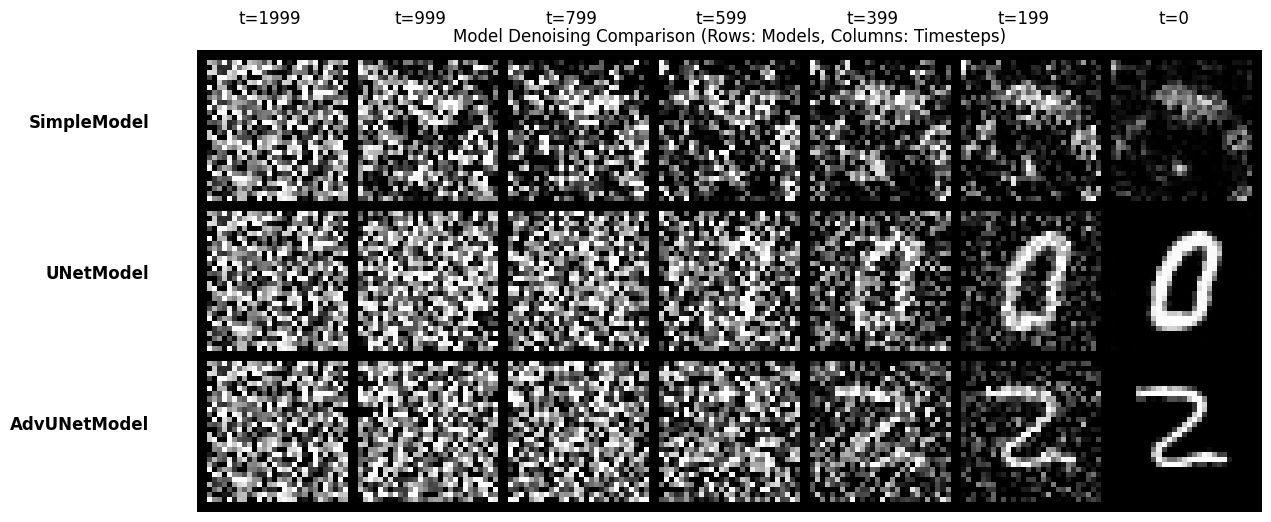

In [ ]:
if all_models_loaded:
    # --- 5. Create the 3xK Grid for Display ---
    display_grid = []
    for model_img_list in captured_images:
        display_grid.extend(model_img_list)

    # Concatenate all images into a single batch
    image_batch = torch.cat(display_grid, dim=0)

    # Use torchvision.utils.make_grid to create a single grid image
    # nrow=K will create K columns
    grid_tensor = torchvision.utils.make_grid(
        image_batch,
        nrow=K
    )

    # --- 6. Plot the Grid ---
    
    # Convert tensor to numpy array
    # .permute(1, 2, 0) changes from (C, H, W) to (H, W, C) for matplotlib
    grid_numpy = grid_tensor.permute(1, 2, 0).numpy()

    # Set the figure size
    plt.figure(figsize=(K * 2, 3 * 2)) # (width, height) in inches
    
    # Display the image
    # .squeeze() removes the channel dim for grayscale
    plt.imshow(grid_numpy.squeeze(), cmap='gray')
    
    # Add titles and labels
    plt.title("Model Denoising Comparison (Rows: Models, Columns: Timesteps)")
    plt.axis('off') # Hide axes
    
    # Add labels for rows (Models)
    ax = plt.gca()
    for i, name in enumerate(model_names):
        ax.text(-10, (i + 0.5) * 28 + i*2, name, # x, y, text
                horizontalalignment='right', 
                verticalalignment='center', 
                fontsize=12, 
                fontweight='bold')
    
    # Add labels for columns (Timesteps)
    for j, step in enumerate(steps_to_display):
         ax.text((j + 0.5) * 28 + j*2, -5, f"t={step}", # x, y, text
                horizontalalignment='center', 
                verticalalignment='bottom', 
                fontsize=12)

    plt.show()

--- Generating grid for AdvUNetModel ---
Running denoising loop...
Denoising complete.


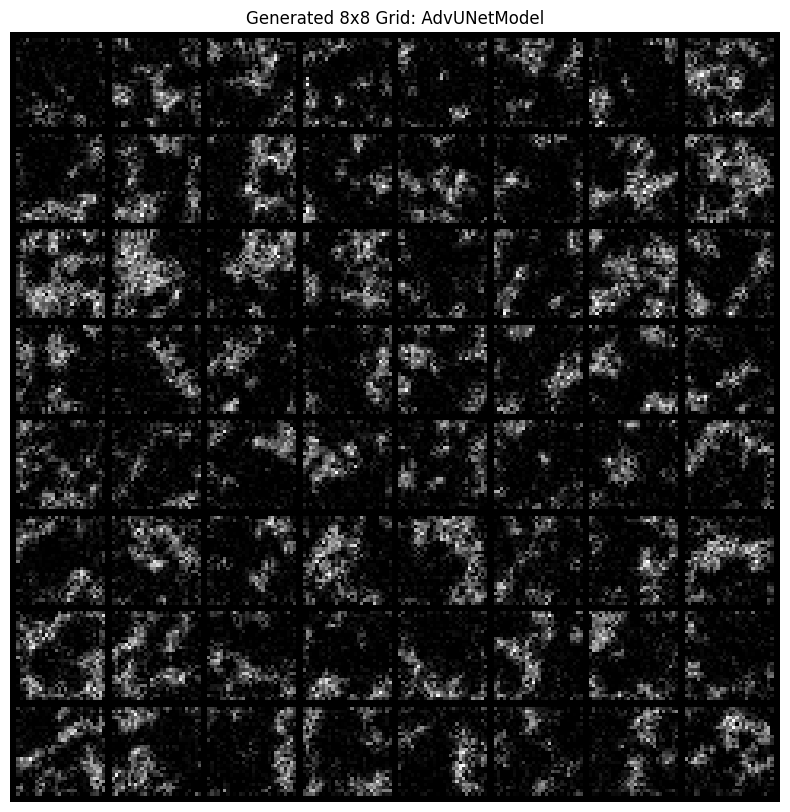

Running denoising loop...
Denoising complete.


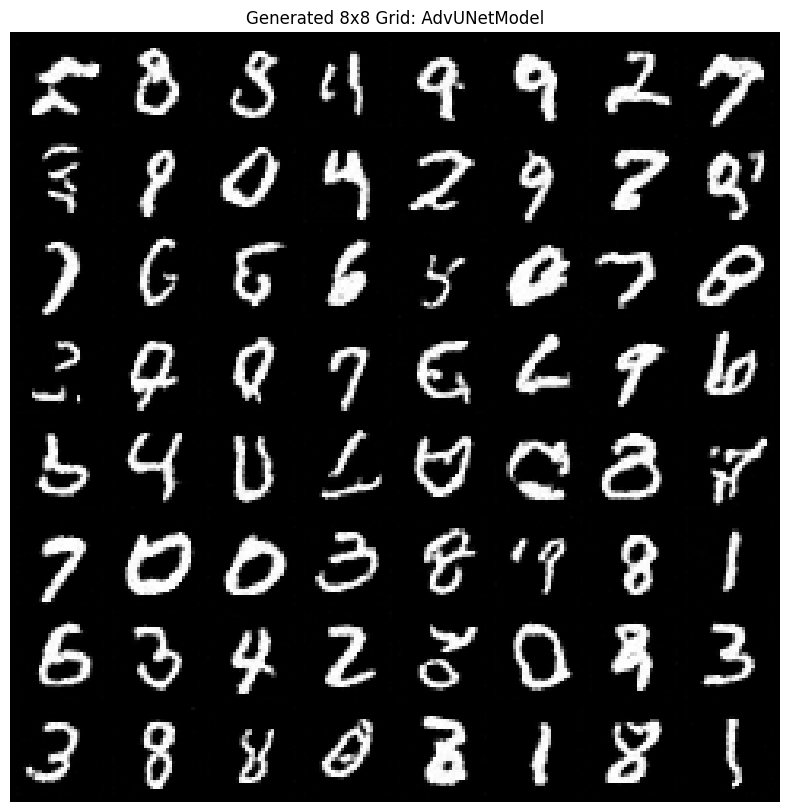

Running denoising loop...
Denoising complete.


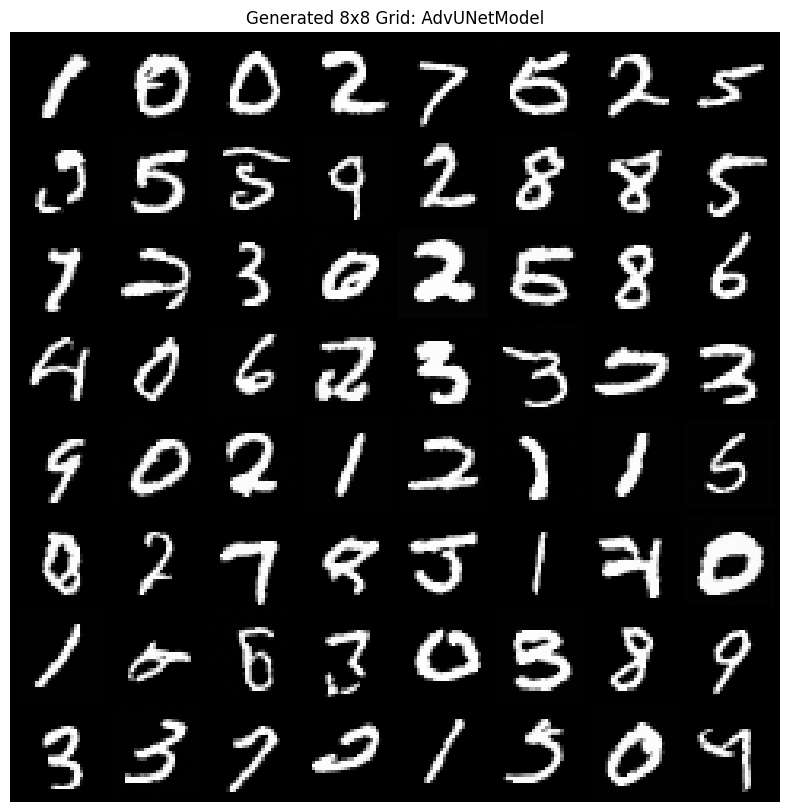

In [5]:
from torchvision.utils import make_grid

if all_models_loaded:
    noise_scheduler = Alpha_NoiseScheduler(steps=num_steps, beta_start=1e-4, beta_end=0.02, device=device)
    print(f"--- Generating grid for {model_class.__name__} ---")
    for model in models:
    # --- 2. Sampling Loop ---
    # Generate a batch of 64 noise samples
        x = torch.randn(64, 1, 28, 28).to(device)
        
        print("Running denoising loop...")
        for step in range(num_steps - 1, -1, -1):
            with torch.no_grad():
                # Create a batch of timestep tensors
                t = torch.tensor(step, device=device).expand(x.size(0),)
                pred_noise = model(x, t)
                x = noise_scheduler.sample_prev_step(x, t, pred_noise)

        print("Denoising complete.")
        
        # --- 3. Denormalize and Plot ---
        x = denormalize(x).clamp(0, 1)

        # Create an 8x8 image grid
        grid = make_grid(x, nrow=8, padding=2)
        
        # Convert from (C, H, W) to (H, W, C) for matplotlib
        grid_numpy = grid.cpu().permute(1, 2, 0)

        plt.figure(figsize=(10, 10))
        plt.imshow(grid_numpy.squeeze(), cmap='gray')
        plt.title(f"Generated 8x8 Grid: {model_class.__name__}")
        plt.axis('off')
        plt.show()